In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [3]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '
dest_path = 'GW_HF_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/GW_HF_analysis/ '/m100_work/IscrC_XEXIN/Germanene/GW_HF_analysis'


In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes',# ,'fastnodes'
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True)#,clean_restart=False) #,clean_restart=False,skip=False)
code.global_options()

In [3]:
# RunRules for m100
nodes = 8 # 32
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',#,qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '230GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_AlNWS2',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

# BSE analysis of the Germanene

We solve the BSE equations and computed the optical spectrum of the Germanene.

We analyze the excitonic spectrum to understand if the system behaves as an excitonic
insulator.

In [4]:
run_dir = 'GW_HF_analysis/kpoints_60-nbnds_700/'
ndbQP = 'allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300/ndb.QP'

In [5]:
cut_z = 30 # 60 # au, slightly smaller than the cell, in agreement with the Yambo tutorial page
RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first 100 G-components of the coulomb potential 

## Absorption spectrum in the IP regime

In [31]:
inp = I.YamboInput(args='mpirun -np 1 yambo -r -o c -V all',folder=run_dir)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']

inp['variables']['LongDrXd'] = [[1.,0.,0.],''] # electric field
inp['variables']['DmRngeXd'] = [[0.01,0.01],'eV'] # damping range
inp['variables']['EnRngeXd'] = [[0,1],'eV'] # energy range
inp['variables']['BndsRnXd'] = [[25,32],''] # bands used for transitions
inp['variables']['QpntsRXd'] = [[1,1],''] # momentum transfer

inp['variables']['XfnQPdb']= 'E < %s'%ndbQP
#inp

In [32]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True,skip=False)
study.set_postprocessing_function(PP.yambo_parse_data)

#idd = 'bse_-BSENGexx_%s-BSENGblk_%s-BSEBands_%s-%s'%(BSENGexx,BSENGBlk,BSEBands[0],BSEBands[1])
idd = 'ip_absorption'
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300',\
                            'ndb_double_grid','allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300'])

Initialize a Dataset with 1 parallel tasks


In [33]:
#study.runs[0]

In [34]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_HF_analysis/kpoints_60-nbnds_700/job_ip_absorption.out
delete folder: GW_HF_analysis/kpoints_60-nbnds_700/ip_absorption
run command: mpirun -np 16 yambo -F ip_absorption.in -J "ip_absorption,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid,allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300" -C ip_absorption
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_ip_absorption.sh
computation ip_absorption is running...
computation ip_absorption ended
Run performed in 11s
Task [0] ended 
 


In [35]:
r = results[0].data

In [36]:
r.keys()

dict_keys(['data', 'fit', 'eps_q1_ip', 'alpha_q1_ip'])

In [37]:
eps = r['eps_q1_ip']
#eps = r['alpha_q1_ip']

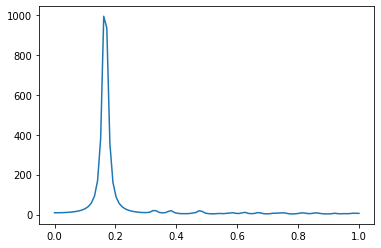

In [38]:
plt.plot(eps['col0'],eps['col1'])

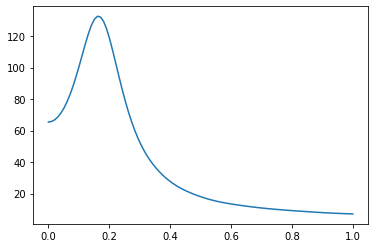

In [22]:
plt.plot(eps['col0'],eps['col1'])

## Computation of the BSE Kernel for subsequent diagonalization

In [6]:
BSENGexx = 11000 #11000
BSENGBlk = 300 
BSEBands = [25,32]
ntasks_c = 16 # ismhpc: 16 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -o b -k sex -V all',folder=run_dir)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']

inp['variables']['BSENGexx'] = [BSENGexx,'RL'] 
inp['variables']['BSENGBlk'] = [BSENGBlk,'RL']
inp['variables']['BSEBands'] = [BSEBands,'']

inp['variables']['KfnQPdb']= 'E < %s'%ndbQP

# Parallel roles
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['BS_ROLEs'] = 'k.eh.t' 
inp['variables']['BS_CPU'] = '4.8.1' # 2 nodes ismhpc and 8 nodes m100

#inp

16 2


In [7]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True)
#study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'bse-BSENGexx_%s-BSENGblk_%s-BSEBands_%s-%s'%(BSENGexx,BSENGBlk,BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300',\
                            'ndb_double_grid','allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300'])

Initialize a Dataset with 1 parallel tasks


In [8]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700/',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -o b -k sex -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'bse', 'optics', 'setup', 'photolum'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'DIP_Threads': [0.0, ''],
   'BS_nCPU_LinAlg_INV': [-1.0, ''],
   'BS_nCPU_LinAlg_DIAGO': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'DipoleEtresh': [1e-05, 'eV'],
   'DbGdQsize': [-1.0, ''],
   'BSENGexx': [11000, 'RL'],
   'BSENGBlk': [300, 'RL'],


In [ ]:
study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.in -J "bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid,allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300" -C bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.sh
computation bse-BSENGexx_11000-BSENGblk_300-BSEBands_25-32 is running...
Submitted batch job 5912416


## Solution of the BSE equations without I/O of the BSE Kernel

In [15]:
BSENGexx = 11000 #11000
BSENGBlk = 300 #300 
BSEBands = [25,32]
BEnRange = [-1.,1.] # eV
ntasks_c = 16 # ismhpc: 16 for 2 nodes # m100: 8 for 2 nodes
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

inp = I.YamboInput(args='mpirun -np 1 yambo -r -o b -k sex -y s -V all',folder=run_dir)
inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvec'] = [RandGvec,'']
inp['variables']['CUTGeo'] = 'box z'
inp['variables']['CUTBox'] = [[0.,0.,cut_z],'au']

inp['variables']['DBsIOoff'] = 'BS'

inp['variables']['BSENGexx'] = [BSENGexx,'RL'] 
inp['variables']['BSENGBlk'] = [BSENGBlk,'RL']
inp['variables']['BSEBands'] = [BSEBands,'']

inp['variables']['BEnRange'] = [BEnRange,'eV']
inp['variables']['BEnSteps']  = [1000,'']
inp['variables']['BDmRange'] = [[0.01,0.01],'eV']

inp['variables']['KfnQPdb']= 'E < %s'%ndbQP

inp['variables']['BSEprop'] = 'abs esrt jdos'
inp['variables']['BSSNEig'] = [20,'']

# Parallel roles
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['BS_ROLEs'] = 'k.eh.t' 
inp['variables']['BS_CPU'] = '4.8.1' # 2 nodes ismhpc and 8 nodes m100
#inp['variables']['BS_CPU'] = '1.8.1' # 2 nodes m100

#inp

16 2


In [16]:
study = D.Dataset(run_dir=run_dir,num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

idd = 'bse_diago-BSENGexx_%s-BSENGblk_%s-BSEBands_%s-%s'%(BSENGexx,BSENGBlk,BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,
                 jobname = [idd,'ndb_cutoff_rim_dipoles_hf','ndb_pp_dg_ngsblkxs_600-bndsrnxs_300',\
                            'ndb_double_grid','allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300'])

Initialize a Dataset with 1 parallel tasks


In [17]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_HF_analysis/kpoints_60-nbnds_700/',
 'num_tasks': 1,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 yambo -r -o b -k sex -y s -V all',
  'folder': 'GW_HF_analysis/kpoints_60-nbnds_700/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut',
   'bse',
   'optics',
   'bss',
   'setup',
   'WRbsWF',
   'photolum'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'FFTGvecs': [17211.0, 'RL'],
   'DIP_Threads': [0.0, ''],
   'BS_nCPU_LinAlg_INV': [-1.0, ''],
   'BS_nCPU_LinAlg_DIAGO': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [1000000, ''],
   'RandGvec': [100, ''],
   'IDEm1Ref': [0.0, ''],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'DipoleEtresh': [1e-05, 'eV'],
   'DbGdQsize': [-1.0, ''],
   'BSENGexx': [11

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.in -J "bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32,ndb_cutoff_rim_dipoles_hf,ndb_pp_dg_ngsblkxs_600-bndsrnxs_300,ndb_double_grid,allBz_ppa_dg-ngsblkxs_600-bndsrnxs_300-gbndrnge_300" -C bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32
slurm submit:  cd GW_HF_analysis/kpoints_60-nbnds_700/ ; sbatch job_bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32.sh
computation bse_diago-BSENGexx_11000-BSENGblk_300-BSEBands_25-32 is running...
Submitted batch job 5911170


In [91]:
r = results[0].data

In [92]:
r.keys()

dict_keys(['in', 'GW_HF_analysis/kpoints_60-nbnds_700/bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32/r-bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32_rim_cut_optics_dipoles_bss_bse', 'eps_q1_slepc_bse', 'alpha_q1_slepc_bse', 'jdos_q1_slepc_bse', 'E_IP_q1', 'Esort_q1_slepc_bse'])

In [93]:
eps = r['eps_q1_slepc_bse']

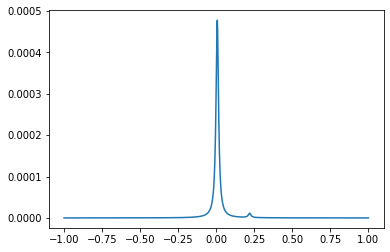

In [94]:
plt.plot(eps['col0'],eps['col1'])

In [101]:
jdos = r['jdos_q1_slepc_bse']

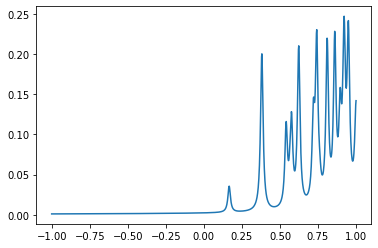

In [106]:
plt.plot(jdos['col0'],jdos['col3'])

In [97]:
energies = Tools.get_variable_from_db(
        'GW_HF_analysis/kpoints_60-nbnds_700/bse_diago-BSENGexx_1000-BSENGblk_100-BSEBands_25-32_old/ndb.BS_diago_Q1','BS_Energies')
energies *= Const.HaToeV*1e3

In [100]:
energies[0:10]

array([[  6.6400695,   0.       ],
       [  6.645164 ,   0.       ],
       [  7.1321254,   0.       ],
       [  7.13764  ,   0.       ],
       [  7.6836133,   0.       ],
       [  7.6873198,   0.       ],
       [  7.848302 ,   0.       ],
       [  7.848533 ,   0.       ],
       [212.92122  ,   0.       ],
       [212.92865  ,   0.       ]], dtype=float32)